In [11]:
!pip install wikitextparser
!pip install plotly
!pip install numpy

In [22]:
import wikitextparser as wtp
import requests
import json
import re
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

headers = {'User-Agent': 'Jupyter Notebook'}
r = requests.get('http://en.wikipedia.org/w/index.php?title=List_of_best-selling_albums_by_year_in_the_United_Kingdom&action=raw', headers=headers)
wt = wtp.parse(r.text)

global bestSellers
bestSellers = wt.tables[0].data()

print(len(bestSellers))

# print(wt.tables[0].data()[0:10][2][1].split('(', 1)[0].rsplit('[', 1)[1])
# print(wt.tables[0].data()[0:10][2][2].split('[', 2)[2].rsplit(']', 2)[0])


71


In [23]:
import sqlite3

db = sqlite3.connect(':memory:')
cursor = db.cursor()

query = '''DROP TABLE IF EXISTS Artists;'''
cursor.execute(query)
query = '''DROP TABLE IF EXISTS BestSellers;'''
cursor.execute(query)

query = '''CREATE TABLE Artists (id INTEGER, name TEXT, PRIMARY KEY (id AUTOINCREMENT));'''
cursor.execute(query)

query = '''CREATE TABLE BestSellers (year INTEGER, album TEXT, artist_id INTEGER REFERENCES Artists(id), sold INTEGER, PRIMARY KEY (year));'''
cursor.execute(query)

artistsSeen = []
del bestSellers[0]

for entry in bestSellers:
    fs = entry[2].split('[', 2)
    name = ""
    if len(fs) > 1:
        name = entry[2].split('[', 2)[len(fs) - 1].rsplit(']', 2)[0].split('(', 1)[0]
    else: 
        s = entry[2].split('[', 2)[len(fs) - 1].rsplit(']', 2)[0].split('(', 1)[0].rsplit('}', 2)[0].split('|', 1)
        name = s[len(s) - 1].replace('|', ' ')
    if name not in artistsSeen:
        query = "INSERT INTO Artists (name) VALUES ('" + name + "');"
        cursor.execute(query)
        artistsSeen.append(entry[2])
        
    query = "SELECT id FROM Artists WHERE name = '" + name + "';"
    cursor.execute(query)
    # print(cursor.fetchone()[0])
    artistId = cursor.fetchone()[0]
    amt = "0"
    # print (json.dumps(entry))
    if (entry[3] != ''):
        amt = entry[3].replace(',', '')

    album = entry[1].split('(', 1)[0].rsplit('[', 1)[1]
    if ']' in album:
        album = album.rsplit(']', 2)[0]

    if album[-1] == ' ':
        album = album[:-1]
        
    query = '''INSERT INTO BestSellers (year, album, artist_id, sold) VALUES (?, ?, ?, ?);'''
    cursor.execute(query, (entry[0], album, artistId, amt))

In [24]:
query = '''SELECT year, album, Artists.name AS 'name', sold FROM BestSellers JOIN Artists ON Artists.id = BestSellers.artist_id;'''
cursor.execute(query)
all_rows = cursor.fetchall()
for row in all_rows:
  print(row)

(1956, 'Carousel', 'Original soundtrack', 0)
(1957, 'The King and I', 'Original soundtrack', 0)
(1958, 'My Fair Lady', 'Cast recording', 0)
(1959, 'South Pacific', 'Original soundtrack', 0)
(1960, 'South Pacific', 'Original soundtrack', 0)
(1961, 'G.I. Blues', 'Elvis Presley', 0)
(1962, 'West Side Story', 'Original soundtrack', 0)
(1963, 'With the Beatles', 'The Beatles', 0)
(1964, 'Beatles for Sale', 'The Beatles', 0)
(1965, 'The Sound of Music', 'Original soundtrack', 0)
(1966, 'The Sound of Music', 'Original soundtrack', 0)
(1967, "Sgt. Pepper's Lonely Hearts Club Band", 'The Beatles', 751000)
(1968, 'The Sound of Music', 'Original soundtrack', 0)
(1969, 'Abbey Road', 'The Beatles', 0)
(1970, 'Bridge over Troubled Water', 'Simon and Garfunkel', 0)
(1971, 'Bridge over Troubled Water', 'Simon and Garfunkel', 0)
(1972, '20 Dynamic Hits', 'Various Artists', 0)
(1973, 'Aladdin Sane', 'David Bowie', 0)
(1974, 'The Singles: 1969–1973', 'The Carpenters', 0)
(1975, 'The Best of the Stylistic

In [25]:
query = '''SELECT COUNT(*) FROM BestSellers;'''
cursor.execute(query)
rows = cursor.fetchone()
print(rows[0])

70


In [26]:
# Who has sold the most albums since 2000?

query = '''SELECT Artists.name AS 'name', SUM(sold) AS 'total' FROM BestSellers JOIN Artists ON Artists.id = BestSellers.artist_id WHERE year >= 2000 GROUP BY artist_id ORDER BY total DESC;'''
cursor.execute(query)
global all_rows
all_rows = cursor.fetchall()
for row in all_rows:
  print(row)

('Adele', 7621346)
('Ed Sheeran', 4389000)
('Dido ', 4088469)
('James Blunt', 2367758)
('Amy Winehouse', 1883897)
('The Beatles', 1850101)
('Take That', 1841148)
('Duffy ', 1685000)
('Susan Boyle', 1632732)
('Original soundtrack', 1600000)
('Scissor Sisters', 1594259)
('Snow Patrol', 1514554)
('Taylor Swift', 1425800)
('Robbie Williams', 1410931)
('Emeli Sandé', 1393000)
('Lewis Capaldi', 1097000)
('One Direction', 685000)
('Harry Styles', 460000)
('The Weeknd', 391000)


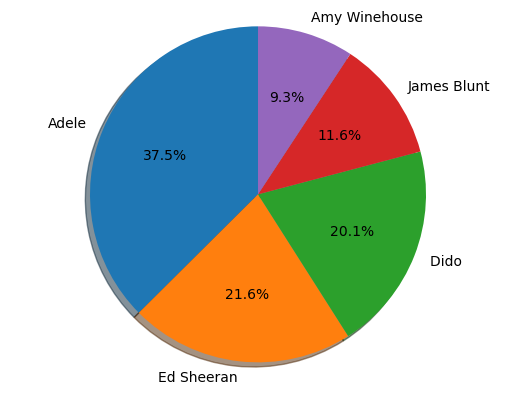

In [30]:
## now convert it to a pie chart

# process the data returned
labels = []
sizes = []
count = 0
i = 0
for row in all_rows[0:5]:
    count += int(row[1])
    sizes.append(row[1])
    labels.append(row[0])

# plot the pie chart
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [137]:
# Who has had the most induvidual albums come up as most sold that year, since 2000
query = '''SELECT Artists.name AS 'name', COUNT(*) AS 'amount' FROM BestSellers JOIN Artists ON Artists.id = BestSellers.artist_id WHERE year >= 2000 GROUP BY artist_id ORDER BY amount DESC;'''
cursor.execute(query)
all_rows = cursor.fetchall()
for row in all_rows:
  print(row)

('Adele', 4)
('Taylor Swift', 2)
('Lewis Capaldi', 2)
('Ed Sheeran', 2)
('Dido ', 2)
('The Weeknd', 1)
('Harry Styles', 1)
('One Direction', 1)
('Emeli Sandé', 1)
('Take That', 1)
('Susan Boyle', 1)
('Duffy ', 1)
('Amy Winehouse', 1)
('Snow Patrol', 1)
('James Blunt', 1)
('Scissor Sisters', 1)
('Robbie Williams', 1)
('The Beatles', 1)
('Original soundtrack', 1)


In [139]:
# Which year had the most albumns sold since 1995
query = '''SELECT year, sold FROM BestSellers WHERE year >= 1995 ORDER BY sold DESC;'''
cursor.execute(query)
all_rows = cursor.fetchall()
for row in all_rows:
  print(row)

(2011, 3772346)
(2017, 2700000)
(2015, 2496000)
(2005, 2367758)
(1999, 2201842)
(2003, 2168302)
(1995, 2040000)
(2001, 1920167)
(2007, 1883897)
(2000, 1850101)
(2010, 1841148)
(1997, 1740000)
(2014, 1689000)
(2008, 1685000)
(1998, 1676439)
(2009, 1632732)
(1996, 1627000)
(2018, 1600000)
(2004, 1594259)
(2006, 1514554)
(2002, 1410931)
(2012, 1393000)
(2024, 783800)
(2016, 753000)
(2013, 685000)
(2025, 642000)
(2019, 641000)
(2021, 600000)
(2022, 460000)
(2020, 456000)
(2023, 391000)


In [143]:
# Have any albums appeared more than once?
query = '''SELECT * FROM (SELECT album, Artists.name AS 'artist', COUNT(*) AS 'amount' FROM BestSellers JOIN Artists ON Artists.id = BestSellers.artist_id GROUP BY album ORDER BY amount DESC) WHERE amount > 1;'''
cursor.execute(query)
all_rows = cursor.fetchall()
for row in all_rows:
  print(row)

('The Sound of Music', 'Original soundtrack', 3)
('Stars', 'Simply Red', 2)
('South Pacific', 'Original soundtrack', 2)
('Divinely Uninspired to a Hellish Extent', 'Lewis Capaldi', 2)
('Bridge over Troubled Water', 'Simon and Garfunkel', 2)
('25', 'Adele', 2)


In [32]:
# Amount of sales over time
query = '''SELECT year, sold FROM BestSellers WHERE year >= 1995 ORDER BY year;'''
cursor.execute(query)
all_rows = cursor.fetchall()
for row in all_rows:
  print(row)

(1995, 2040000)
(1996, 1627000)
(1997, 1740000)
(1998, 1676439)
(1999, 2201842)
(2000, 1850101)
(2001, 1920167)
(2002, 1410931)
(2003, 2168302)
(2004, 1594259)
(2005, 2367758)
(2006, 1514554)
(2007, 1883897)
(2008, 1685000)
(2009, 1632732)
(2010, 1841148)
(2011, 3772346)
(2012, 1393000)
(2013, 685000)
(2014, 1689000)
(2015, 2496000)
(2016, 753000)
(2017, 2700000)
(2018, 1600000)
(2019, 641000)
(2020, 456000)
(2021, 600000)
(2022, 460000)
(2023, 391000)
(2024, 783800)
(2025, 642000)


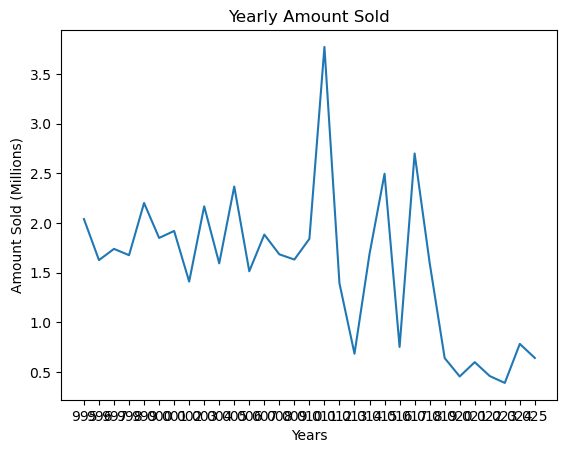

In [56]:
## Now as a line chart
year = []
amt = []
for y in all_rows:
    amt.append(y[1] / 1000000)
count = 1995
while count <= 2025:
    year.append(str(count)[1:])
    count = count + 1

plt.plot(year, amt)
plt.title('Yearly Amount Sold')
plt.xlabel('Years')
plt.ylabel('Amount Sold (Millions)')
plt.show()